In [9]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint 
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp 
import utils
import time
import random
import pickle
import math

### Create multiple constrained FLP instances

In [10]:
n_instances = 2
N_range = [int(100+100*n) for n in range(n_instances)]
M_range = [int(3+0.5*m) for m in range(n_instances)]
cov_range = [3+2*p for p in range(n_instances)]
d = 2
scale = 20
seed = 12
N_range, M_range, cov_range

([100, 200], [3, 3], [3, 5])

In [11]:
# annealing parameters
beta0 = 1e-3
betaf = 1e2
beta_grow = 2

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3

# parameters for deterministic annealing based optimization
b1_min = 0.005
b1_max = 200
b1_grow = 5
theta = 5
n_iters = 1000
D_tol = 1e-4


### Generate multiple flp instances

In [12]:
flp_instances = []
for N, M, cov in zip(N_range, M_range, cov_range):
    demandLoc, Y0, demand_means, split_pct, rho = utils.generate_testcase(
    N, M, d, unif_split=False, cluster_cov=cov, seed=seed, sq_size=scale, normalizer=False)
    alloc_cost = np.random.uniform(1,1,(N,M))
    mean_alloc_cost = np.mean(alloc_cost)
    C = np.random.uniform(0.3,1,len(split_pct))
    C = (C/np.sum(C) + 0.02) * mean_alloc_cost
    B = np.random.uniform(C.min()*0.3, C.min()*0.6, len(split_pct))
    flp = class_flp.FLP(N, M, d, demandLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)
    flp_instances.append(flp)

### Solve all the instaces using DA (unconstrained)

In [13]:
DA_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    t0 = time.time()
    F_arr_da, b_arr_da, P_arr_da, Y_arr_da, t_compute_arr_da, cap_arr_da = flp.anneal_DA(Y0, beta0, betaf, beta_grow, n_iters=1000, D_tol=1e-5)
    t1 = time.time()
    sol_instance = {
        'flp':flp,
        'F_arr':F_arr_da,
        'b_arr':b_arr_da,
        'P_arr':P_arr_da,
        'Y_arr':Y_arr_da,
        't_compute_arr':t_compute_arr_da,
        'cap_arr':cap_arr_da,
        'runtime':t1 - t0
    }
    DA_sol_instances.append(sol_instance)


------instance:0------
tolerance achieved: 	 norm_diff_D=1.358e-06
b:1.000e-03	F:27.0735
tolerance achieved: 	 norm_diff_D=2.089e-06
b:2.000e-03	F:27.0744
tolerance achieved: 	 norm_diff_D=2.102e-06
b:4.000e-03	F:27.0743
tolerance achieved: 	 norm_diff_D=6.170e-06
b:8.000e-03	F:27.0753
tolerance achieved: 	 norm_diff_D=9.658e-06
b:1.600e-02	F:27.0734
tolerance achieved: 	 norm_diff_D=9.690e-06
b:3.200e-02	F:24.1888
tolerance achieved: 	 norm_diff_D=8.213e-06
b:6.400e-02	F:15.6344
tolerance achieved: 	 norm_diff_D=9.846e-06
b:1.280e-01	F:9.9776
tolerance achieved: 	 norm_diff_D=7.370e-06
b:2.560e-01	F:6.8473
tolerance achieved: 	 norm_diff_D=8.724e-06
b:5.120e-01	F:5.0039
tolerance achieved: 	 norm_diff_D=6.316e-06
b:1.024e+00	F:3.9893
tolerance achieved: 	 norm_diff_D=4.668e-06
b:2.048e+00	F:3.4660
tolerance achieved: 	 norm_diff_D=3.149e-06
b:4.096e+00	F:3.2006
tolerance achieved: 	 norm_diff_D=3.983e-06
b:8.192e+00	F:3.0671
tolerance achieved: 	 norm_diff_D=4.160e-06
b:1.638e+01	F:2

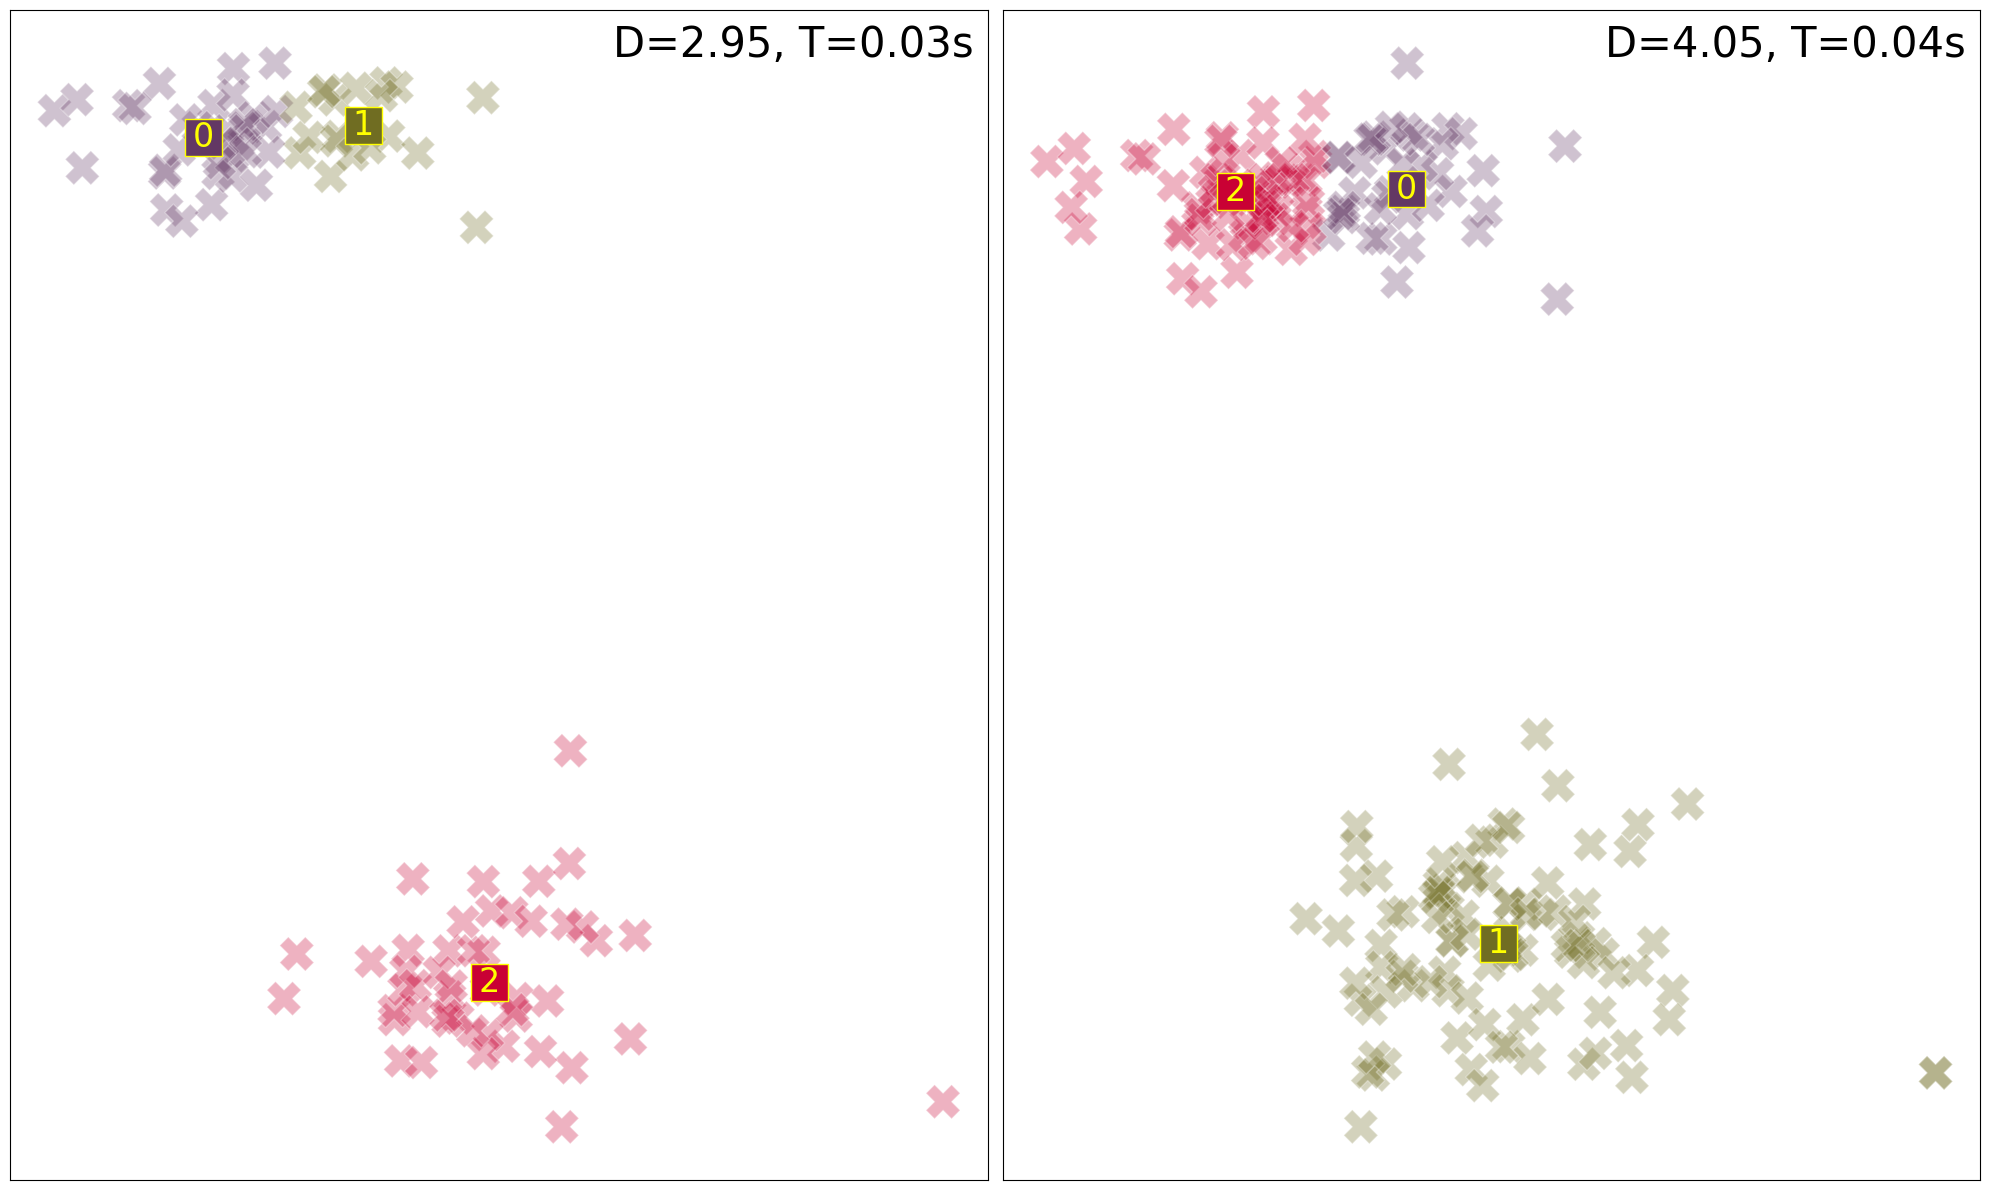

In [14]:
class_flp.plot_flp_sol_instances(
    DA_sol_instances,
    fontSize = 30,
    figSize = (20,12),
    plotResTraj = False
)

### Solve using our CBF approach

In [15]:
CBF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_cbf, b_arr_cbf, P_arr_cbf, Y_arr_cbf, t_compute_arr_cbf, cap_arr_cbf = flp.anneal_CBF_CLF(
        x0, beta0, betaf, beta_grow, p1, p2, gamma, 
        alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, 
        Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'flp':flp,
        'F_arr':F_arr_cbf,
        'b_arr':b_arr_cbf,
        'P_arr':P_arr_cbf,
        'Y_arr':Y_arr_cbf,
        't_compute_arr':t_compute_arr_cbf,
        'cap_arr':cap_arr_cbf,
        'runtime':t1-t0
    }
    CBF_sol_instances.append(sol_instance)


------instance:0------
x0	shape:(306,)
beta:2.000e-03	F:4.536e+01
beta:4.000e-03	F:3.616e+01
beta:8.000e-03	F:3.169e+01
beta:1.600e-02	F:2.919e+01
beta:3.200e-02	F:2.810e+01
beta:6.400e-02	F:2.740e+01
beta:1.280e-01	F:1.785e+01
beta:2.560e-01	F:1.371e+01
beta:5.120e-01	F:1.094e+01
beta:1.024e+00	F:9.358e+00
beta:2.048e+00	F:8.447e+00
beta:4.096e+00	F:7.926e+00
beta:8.192e+00	F:7.669e+00
beta:1.638e+01	F:7.538e+00
beta:3.277e+01	F:7.467e+00
beta:6.554e+01	F:7.432e+00
beta:1.311e+02	F:7.411e+00

------instance:1------
x0	shape:(606,)
beta:2.000e-03	F:2.872e+01
beta:4.000e-03	F:2.796e+01
beta:8.000e-03	F:2.759e+01
beta:1.600e-02	F:2.740e+01
beta:3.200e-02	F:2.732e+01
beta:6.400e-02	F:2.725e+01
beta:1.280e-01	F:1.869e+01
beta:2.560e-01	F:1.391e+01
beta:5.120e-01	F:1.093e+01
beta:1.024e+00	F:9.294e+00
beta:2.048e+00	F:8.298e+00
beta:4.096e+00	F:7.783e+00
beta:8.192e+00	F:7.515e+00
beta:1.638e+01	F:7.376e+00
beta:3.277e+01	F:7.314e+00
beta:6.554e+01	F:7.265e+00
beta:1.311e+02	F:7.245e+00


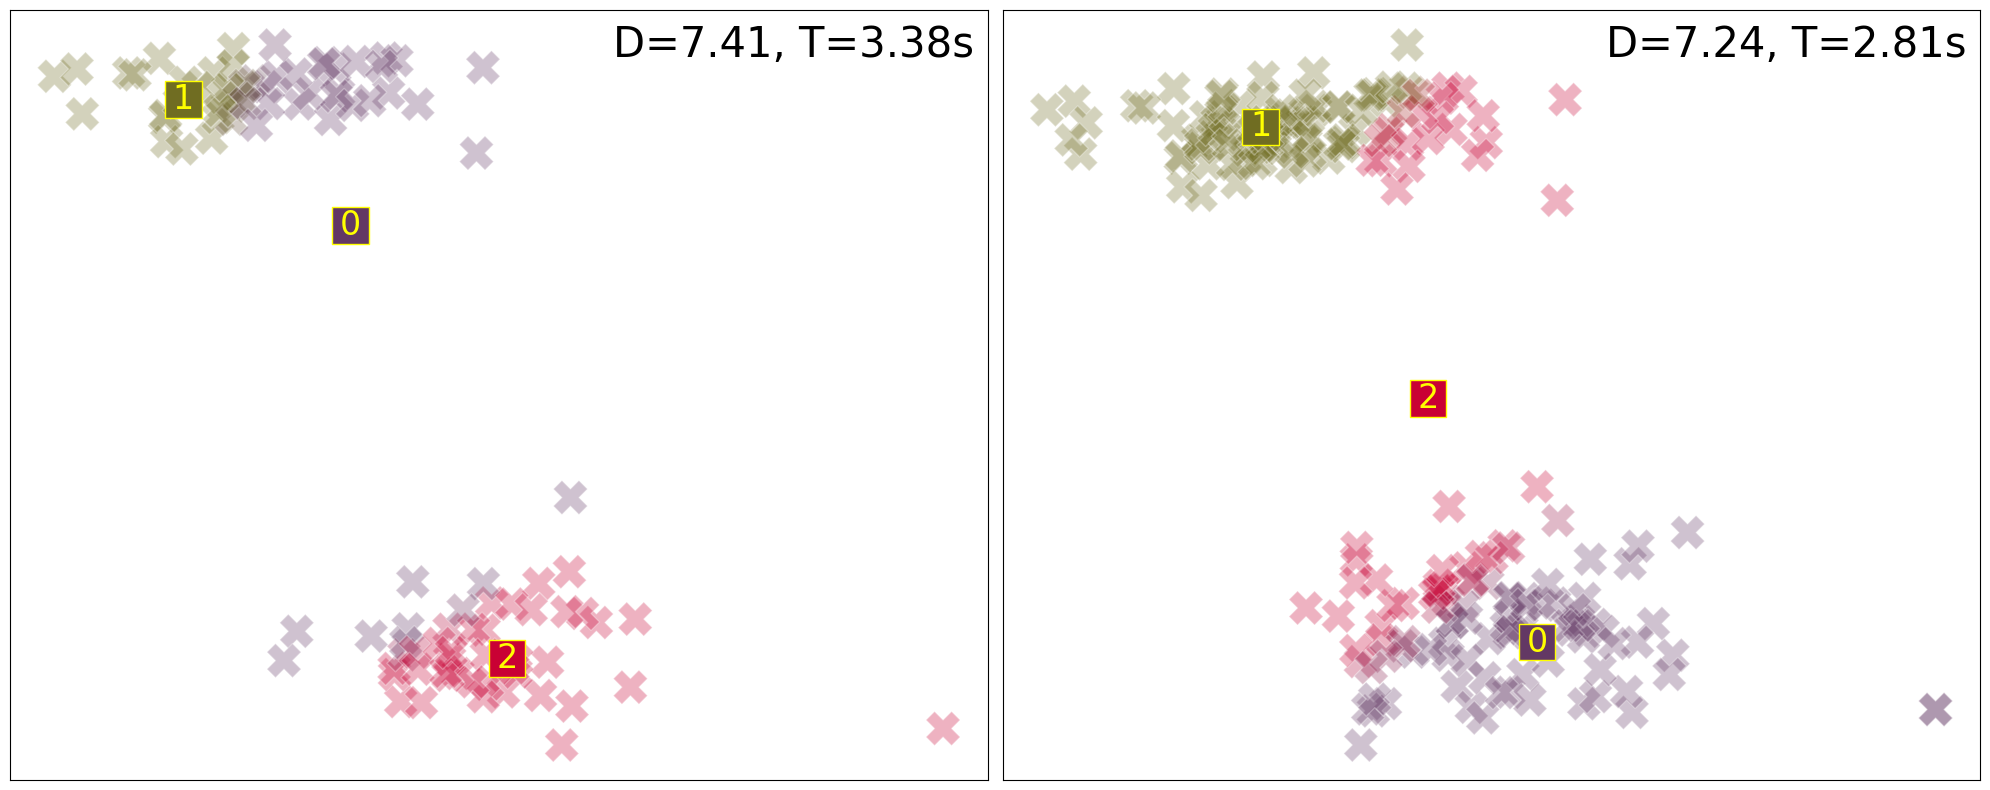

In [16]:
class_flp.plot_flp_sol_instances(
    CBF_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

### Solve using SGF approach

In [17]:
SGF_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_sgf, b_arr_sgf, P_arr_sgf, Y_arr_sgf, t_compute_arr_sgf, cap_arr_sgf = flp.anneal_SGF(
        x0, beta0, betaf, beta_grow, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True, printOptimizeIters=False)
    t1 = time.time()

    sol_instance = {
        'flp':flp,
        'F_arr':F_arr_sgf,
        'b_arr':b_arr_sgf,
        'P_arr':P_arr_sgf,
        'Y_arr':Y_arr_sgf,
        't_compute_arr':t_compute_arr_sgf,
        'cap_arr':cap_arr_sgf,
        'runtime':t1-t0
    }
    SGF_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(306,)
beta:2.000e-03	F:4.537e+01
beta:4.000e-03	F:3.611e+01
beta:8.000e-03	F:3.162e+01
beta:1.600e-02	F:2.936e+01
beta:3.200e-02	F:2.823e+01
beta:6.400e-02	F:2.766e+01
beta:1.280e-01	F:2.737e+01
beta:2.560e-01	F:2.722e+01
beta:5.120e-01	F:1.145e+01
beta:1.024e+00	F:9.838e+00
beta:2.048e+00	F:9.186e+00
beta:4.096e+00	F:8.857e+00
beta:8.192e+00	F:8.693e+00
beta:1.638e+01	F:8.597e+00
beta:3.277e+01	F:8.549e+00
beta:6.554e+01	F:8.519e+00
beta:1.311e+02	F:8.500e+00

------instance:1------
x0	shape:(606,)
beta:2.000e-03	F:2.872e+01
beta:4.000e-03	F:2.800e+01
beta:8.000e-03	F:2.765e+01
beta:1.600e-02	F:2.746e+01
beta:3.200e-02	F:2.736e+01
beta:6.400e-02	F:2.729e+01
beta:1.280e-01	F:2.727e+01
beta:2.560e-01	F:2.726e+01
beta:5.120e-01	F:2.726e+01
beta:1.024e+00	F:2.726e+01
beta:2.048e+00	F:2.725e+01
beta:4.096e+00	F:2.724e+01
beta:8.192e+00	F:2.725e+01
beta:1.638e+01	F:2.726e+01
beta:3.277e+01	F:2.726e+01
beta:6.554e+01	F:2.726e+01
beta:1.311e+02	F:2.725e+01


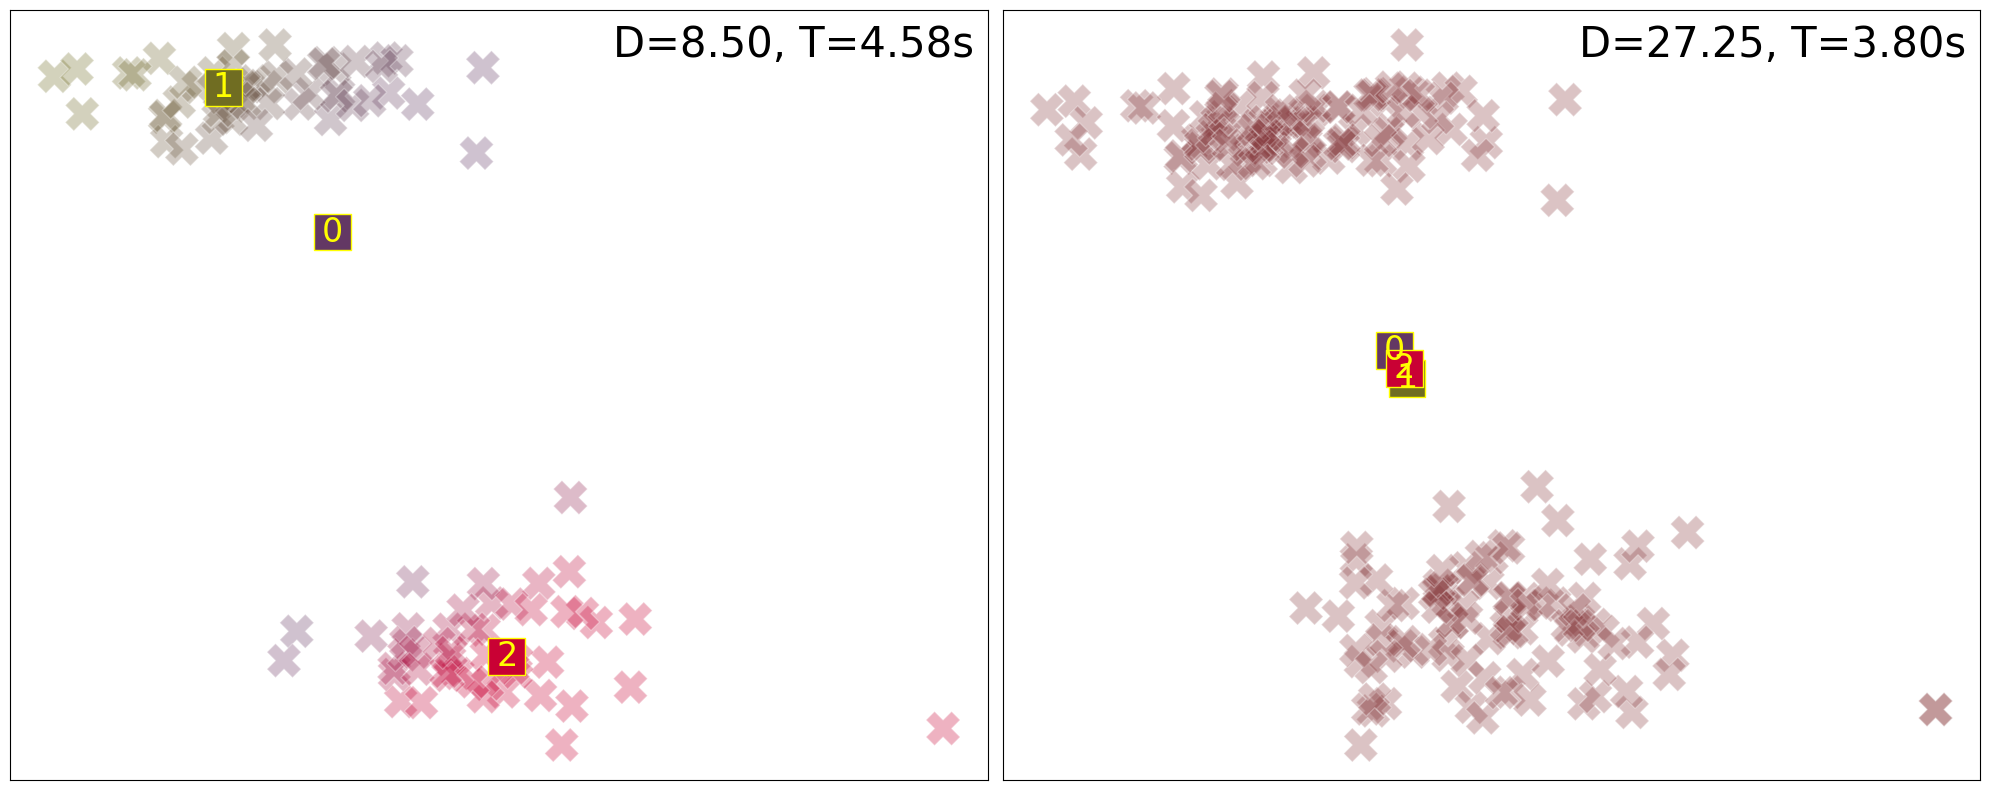

In [18]:
class_flp.plot_flp_sol_instances(
    SGF_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

### Solve using SLSQP

In [19]:
SLSQP_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))
    P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
    P0 = P0/P0.sum(axis=1,keepdims=True)
    x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

    t0 = time.time()
    F_arr_slsqp, b_arr_slsqp, P_arr_slsqp, Y_arr_slsqp, t_compute_arr_slsqp, cap_arr_slsqp = flp.anneal_SLSQP(
        x0, beta0, betaf, beta_grow, Ftol)
    t1 = time.time()

    sol_instance = {
        'flp':flp,
        'F_arr':F_arr_slsqp,
        'b_arr':b_arr_slsqp,
        'P_arr':P_arr_slsqp,
        'Y_arr':Y_arr_slsqp,
        't_compute_arr':t_compute_arr_slsqp,
        'cap_arr':cap_arr_slsqp,
        'runtime':t1-t0
    }
    SLSQP_sol_instances.append(sol_instance)




------instance:0------
x0	shape:(306,)
beta:2.000e-03	F:4.445e+01
beta:4.000e-03	F:3.609e+01
beta:8.000e-03	F:3.158e+01
beta:1.600e-02	F:2.933e+01
beta:3.200e-02	F:2.820e+01
beta:6.400e-02	F:2.764e+01
beta:1.280e-01	F:2.736e+01
beta:2.560e-01	F:2.722e+01
beta:5.120e-01	F:2.714e+01
beta:1.024e+00	F:9.459e+00
beta:2.048e+00	F:8.595e+00
beta:4.096e+00	F:8.045e+00
beta:8.192e+00	F:7.724e+00
beta:1.638e+01	F:7.571e+00
beta:3.277e+01	F:7.515e+00
beta:6.554e+01	F:7.477e+00
beta:1.311e+02	F:7.464e+00

------instance:1------
x0	shape:(606,)
beta:2.000e-03	F:2.870e+01
beta:4.000e-03	F:2.795e+01
beta:8.000e-03	F:2.758e+01
beta:1.600e-02	F:2.740e+01
beta:3.200e-02	F:2.731e+01
beta:6.400e-02	F:2.726e+01
beta:1.280e-01	F:2.724e+01
beta:2.560e-01	F:2.723e+01
beta:5.120e-01	F:2.722e+01
beta:1.024e+00	F:2.722e+01
beta:2.048e+00	F:2.722e+01
beta:4.096e+00	F:2.722e+01
beta:8.192e+00	F:2.722e+01
beta:1.638e+01	F:2.721e+01
beta:3.277e+01	F:2.721e+01
beta:6.554e+01	F:2.721e+01
beta:1.311e+02	F:2.721e+01


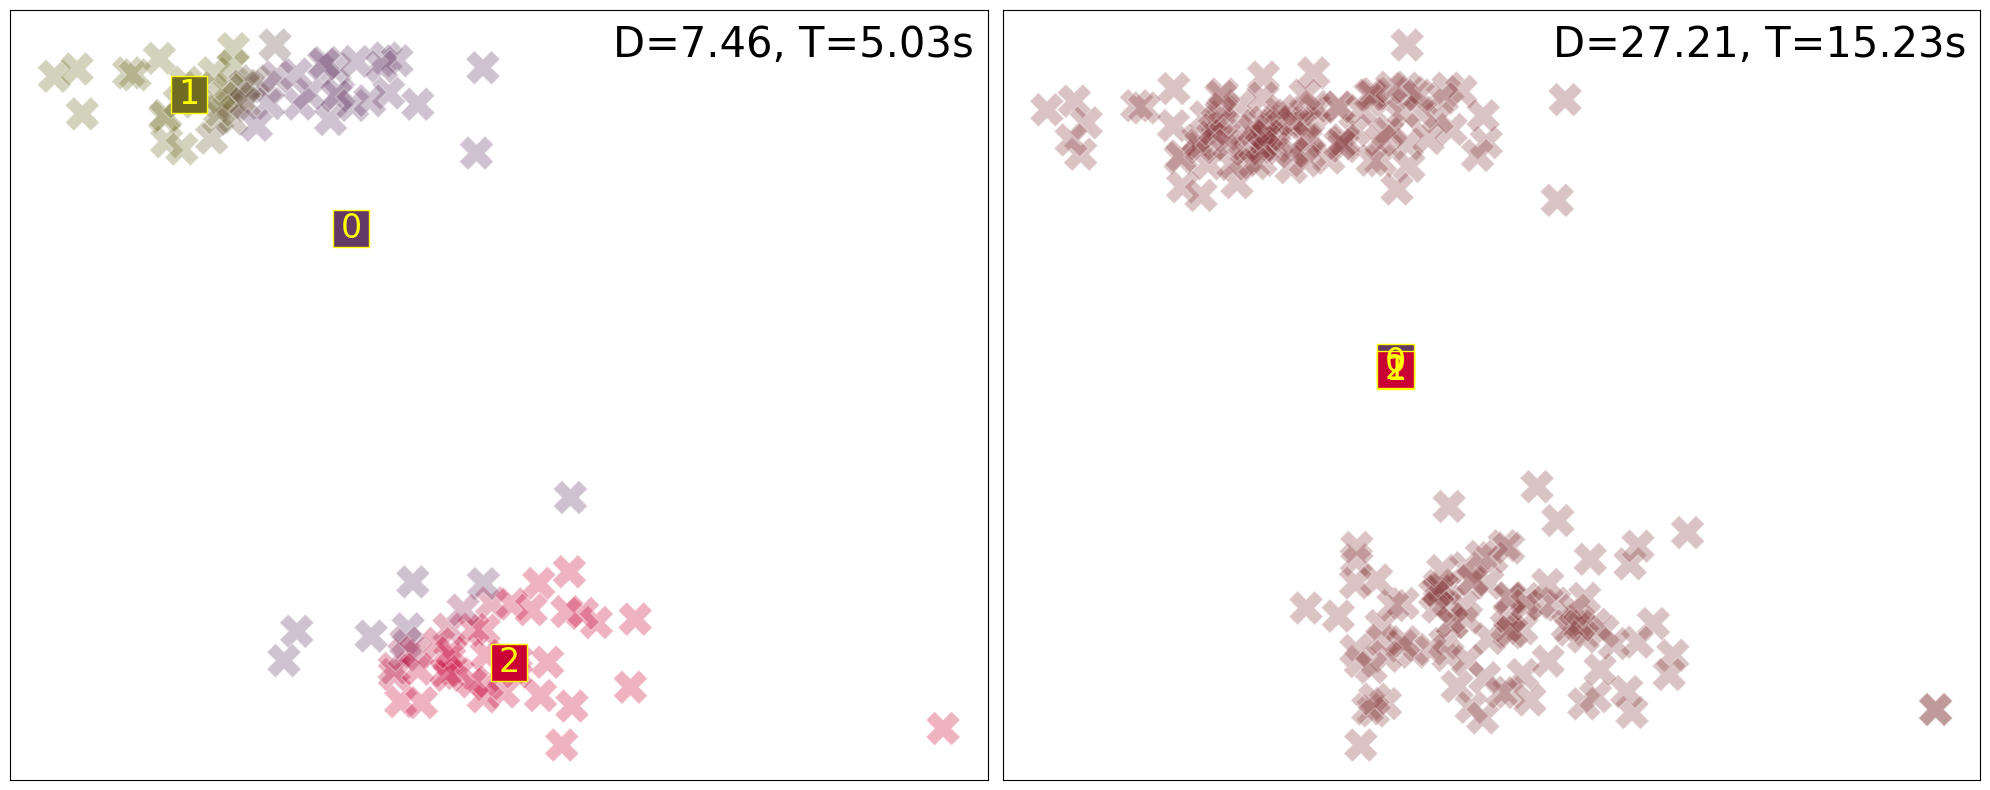

In [20]:
class_flp.plot_flp_sol_instances(
    SLSQP_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)

### Solve using penalty based DA (DA-P)

In [21]:
DAC_sol_instances = []
for i, flp in enumerate(flp_instances):
    print(f'\n------instance:{i}------')
    Y0 = np.random.uniform(-scale, scale,(flp.M,flp.d))

    t0 = time.time()
    F_arr_dac, b_arr_dac, P_arr_dac, Y_arr_dac, t_compute_arr_dac, cap_arr_dac = flp.anneal_DA_C(
        Y0, beta0, betaf, beta_grow, b1_min, b1_max, b1_grow, theta, n_iters, D_tol)
    t1 = time.time()

    sol_instance = {
        'flp':flp,
        'F_arr':F_arr_dac,
        'b_arr':b_arr_dac,
        'P_arr':P_arr_dac,
        'Y_arr':Y_arr_dac,
        't_compute_arr':t_compute_arr_dac,
        'cap_arr':cap_arr_dac,
        'runtime':t1-t0
    }
    DAC_sol_instances.append(sol_instance)




------instance:0------
cons_violation: [-0.098  0.086 -0.048]
b:2.000e-03	b1_min,b1_max:(1e-05, 0.001)	F:27.0723
cons_violation: [-0.098  0.085 -0.048]
b:4.000e-03	b1_min,b1_max:(2e-05, 0.002)	F:27.0723
cons_violation: [-0.096  0.084 -0.047]
b:8.000e-03	b1_min,b1_max:(4e-05, 0.004)	F:27.0723
cons_violation: [-0.094  0.081 -0.046]
b:1.600e-02	b1_min,b1_max:(8e-05, 0.008)	F:27.0723
cons_violation: [-0.09   0.075 -0.044]
b:3.200e-02	b1_min,b1_max:(0.00016, 0.016)	F:27.0723
cons_violation: [-0.109  0.114 -0.065]
b:6.400e-02	b1_min,b1_max:(0.00032, 0.032)	F:24.2254
cons_violation: [-0.161  0.221 -0.12 ]
b:1.280e-01	b1_min,b1_max:(0.00064, 0.064)	F:15.6423
cons_violation: [-0.165  0.233 -0.129]
b:2.560e-01	b1_min,b1_max:(0.00128, 0.128)	F:9.9765
cons_violation: [-0.155  0.234 -0.139]
b:5.120e-01	b1_min,b1_max:(0.00256, 0.256)	F:6.8437
cons_violation: [-0.137  0.234 -0.157]
b:1.024e+00	b1_min,b1_max:(0.00512, 0.512)	F:5.0005
cons_violation: [-0.125  0.234 -0.169]
b:2.048e+00	b1_min,b1_max:(0

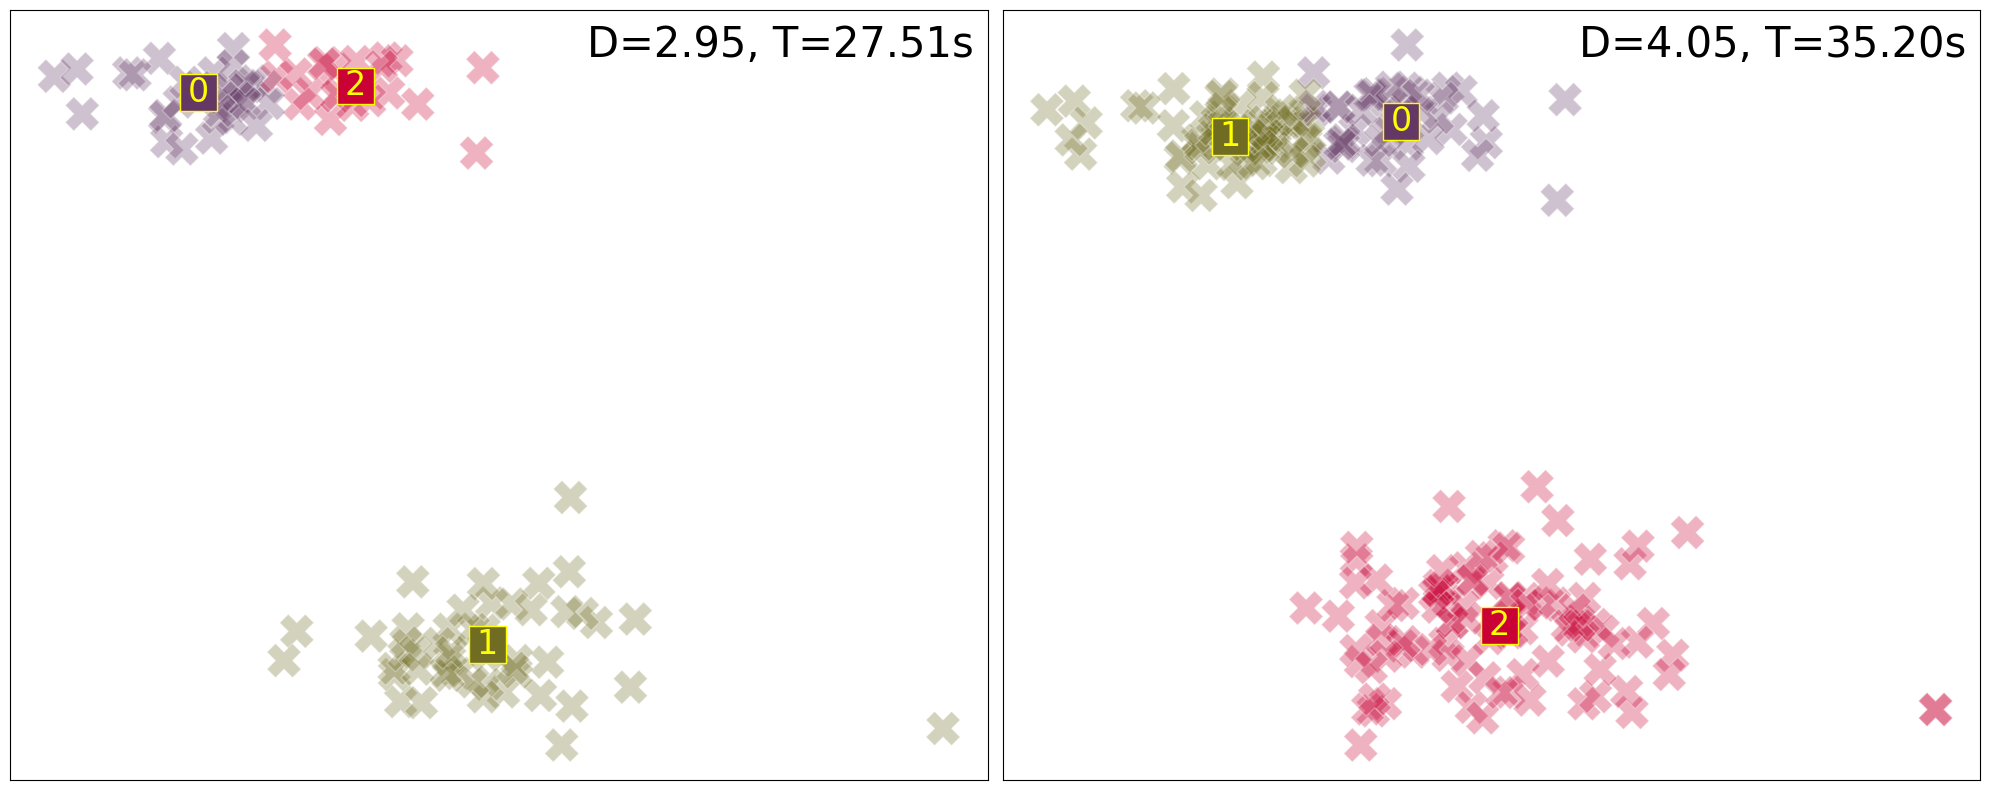

In [22]:
class_flp.plot_flp_sol_instances(
    DAC_sol_instances,
    fontSize = 30,
    figSize = (20,8),
    plotResTraj = False
)